## Important:

This notebook assumes you have done the data preprocessing steps of the cbis-cnn notebook

In [52]:
# import libraries
import numpy as np 
import os
from skimage.io import imread
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.stats import chi2
from sklearn.metrics import confusion_matrix

# import data proprocessing scripts from dataprep.py
from dataprep import load_dataframes, move_masked_images_from_cropped_directories, convert_images_to_png, image_augmentation
from dataprep import apply_clahe_on_images, image_resizing, split_data, create_train_val_test_dirs, print_class_distribution

In [2]:
def load_images_from_directories(folder, label):
    """
    loads the images from the directory structure created by the data preprocessing.
    returns the image as a vector and its label
    """
    images = []
    labels = []

    for filename in os.listdir(folder):

        img_path = os.path.join(folder, filename)
        img = imread(img_path, as_gray=True)
        
        images.append(img.flatten())
        labels.append(label)

    return images, labels

# create the training, testing, and validation sets for logistic regression
base_dir = "../Data/CBIS-DDSM dataset/base_dir"

benign_train_dir = os.path.join(base_dir, "train/benign")
malignant_train_dir = os.path.join(base_dir, "train/malignant")

benign_val_dir = os.path.join(base_dir, "validation/benign")
malignant_val_dir = os.path.join(base_dir, "validation/malignant")

benign_test_dir = os.path.join(base_dir, "test/benign")
malignant_test_dir = os.path.join(base_dir, "test/malignant")

benign_images_train, benign_labels_train = load_images_from_directories(benign_train_dir, label=0)
malignant_images_train, malignant_labels_train = load_images_from_directories(malignant_train_dir, label=1)

benign_images_val, benign_labels_val = load_images_from_directories(benign_val_dir, label=0)
malignant_images_val, malignant_labels_val = load_images_from_directories(malignant_val_dir, label=1)

benign_images_test, benign_labels_test = load_images_from_directories(benign_test_dir, label=0)
malignant_images_test, malignant_labels_test = load_images_from_directories(malignant_test_dir, label=1)

x_train = np.array(benign_images_train + malignant_images_train + benign_images_val + malignant_images_val)
y_train = np.array(benign_labels_train + malignant_labels_train + benign_labels_val + malignant_labels_val)

x_test = np.array(benign_images_test + malignant_images_test)
y_test = np.array(benign_labels_test + malignant_labels_test)

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [11]:
# scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# during cross validation, keep score of estimated coefficients, accuracies, pseudo-R^2,
# lrt statistics, p-values, and the lambda
coeff_list = []
accuracy_list = []
r_list = []
ltr_list = []
p_list = []
lambda_list = [0.1, 0.5, 2, 4, 6]

# cross validate over lambda
for lambda_ in lambda_list:
    print(f'At lambda: {lambda_}', end="\r")

    # sklearn uses 1 / lambda. Initialize logistic regression use saga solver
    C_value = 1 / lambda_
    logistic = LogisticRegression(penalty='l1', C=C_value, solver='saga', max_iter=10000, random_state=0)
    logistic.fit(x_train_scaled, y_train)

    # after fitting, let the model predict the test set, and calculate accuracy and log-likelihood
    y_pred_prob = logistic.predict_proba(x_test_scaled)[:, 1]  
    y_pred_binary = np.where(y_pred_prob > 0.5, 1, 0)

    accuracy = np.mean(y_pred_binary == y_test)

    coefficients = logistic.coef_

    log_likelihood_model = -log_loss(y_train, logistic.predict_proba(x_train_scaled), normalize=False)

    # do the same for null model without any regressors
    null_model = LogisticRegression(penalty=None, C=1, solver='saga', max_iter=10000)
    null_model.fit(np.ones((x_train_scaled.shape[0], 1)), y_train)

    log_likelihood_null = -log_loss(y_train, null_model.predict_proba(np.ones((x_train_scaled.shape[0], 1))), normalize=False)

    # calculate pseudo-R^2, lrt, p-value and store values
    pseudo_r_squared = 1 - (log_likelihood_model / log_likelihood_null)
    ltr = -2 * (log_likelihood_null - log_likelihood_model)

    df = x_train_scaled.shape[1]
    p_value = chi2.sf(ltr, df)

    coeff_list.append(coefficients)
    accuracy_list.append(accuracy)
    r_list.append(pseudo_r_squared)
    ltr_list.append(ltr)
    p_list.append(p_value)

In [42]:
# check for every lambda the sparsity percentage
sparsity_list = []
for i in range(len(coeff_list)):
    sparsity_list.append((np.size(coeff_list[i]) - np.count_nonzero(coeff_list[i])) / np.size(coeff_list[i]) * 100)

In [44]:
# print results
print(f"accuracy: {accuracy_list}")
print(f"pseudo-R2: {r_list}")
print(f"LTR: {ltr_list}")
print(f"p-values: {p_list}")
print(f"Sparsity: {sparsity_list}")

accuracy: [0.6081871345029239, 0.6081871345029239, 0.5964912280701754, 0.5760233918128655, 0.5584795321637427]
pseudo-R2: [0.9082898935206639, 0.8739333514645236, 0.7403261770900119, 0.5760914730193321, 0.4511908969944276]
LTR: [7649.3214963643595, 7359.982657770093, 6234.785810667137, 4851.654653700956, 3799.7827032638243]
p-values: [1.0, 1.0, 1.0, 1.0, 1.0]
Sparsity: [2.419483418367347, 26.55054209183674, 68.15808354591837, 84.5264668367347, 91.37635522959184]


In [65]:
# calculate sensitivity and specificity for best model
coefs = coeff_list[1][0]

model = LogisticRegression()
model.coef_ = np.array([coefs])
model.intercept_ = np.array([logistic.intercept_[0]])
model.classes_ = np.array([0, 1])
y_pred_prob = model.predict_proba(x_test_scaled)[:, 1]
y_pred_binary = np.where(y_pred_prob > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

sensitivity = tp / (tp + fn) 
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.5443037974683544
Specificity: 0.6467391304347826


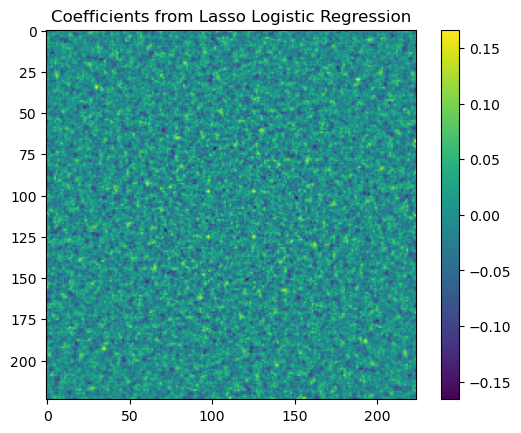

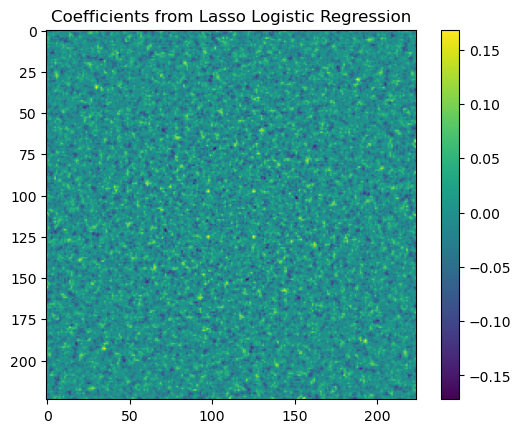

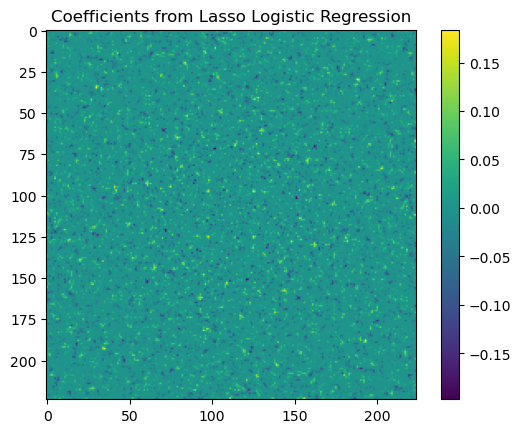

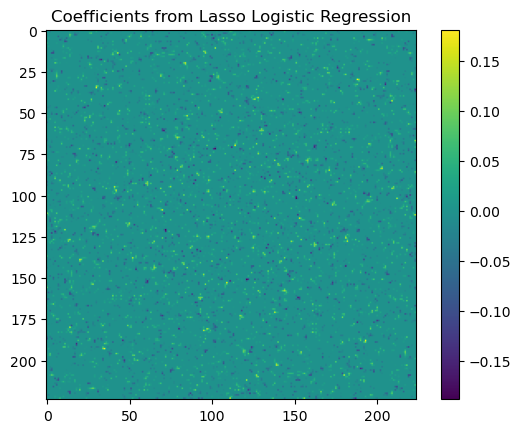

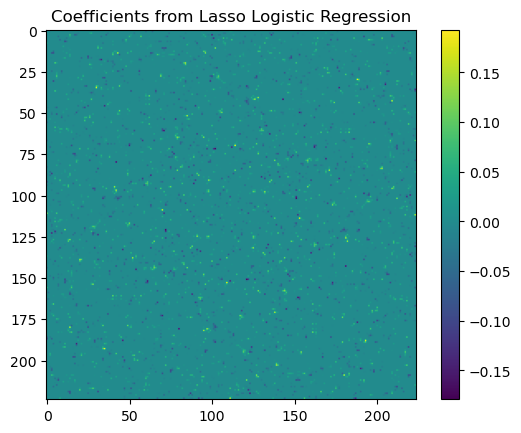

In [15]:
# print the coefficient heatmaps per model with different lambda
for i in range(len(coeff_list)):
    params = coeff_list[i].reshape(224, 224)
    plt.imshow(params, cmap='viridis')
    plt.colorbar()
    plt.title('Coefficients from Lasso Logistic Regression')
    plt.show()